In [ ]:
# Import the packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, mean, count, when
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Spark Initialization"
spark = SparkSession.builder.appName("RealEstateAnalysis").getOrCreate()

In [ ]:
#Loading the data
df = spark.read.csv("real_estate.csv", header=True, inferSchema=True, sep=";")

In [ ]:
# Displaying the column names of the DataFrame
print(df.columns)

['SaleDate', 'SaleType', 'Price', 'PostCode', 'City', 'NbRooms', 'NbLots', 'ResidenceType', 'LivingArea', 'LandArea']


In [ ]:
# Data Cleaning
df = df.dropna()
df = df.withColumn('price_per_m2', col('Price') / col('LivingArea')) # Define a new column "price per m2"
df.show(5) #Display the first 5 rows

+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+------------------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|      price_per_m2|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+------------------+
|15/01/2019|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|2111.1111111111113|
|21/01/2019|    SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|3008.0459770114944|
|03/01/2019|    SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|2295.4545454545455|
|11/01/2019|    SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|2288.4615384615386|
|15/01/2019|    SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|1884.2105263

In [ ]:
from pyspark.sql.functions import to_date

# Convert SaleDate to date type
df = df.withColumn("SaleDate", to_date(col("SaleDate"), "dd/MM/yyyy"))

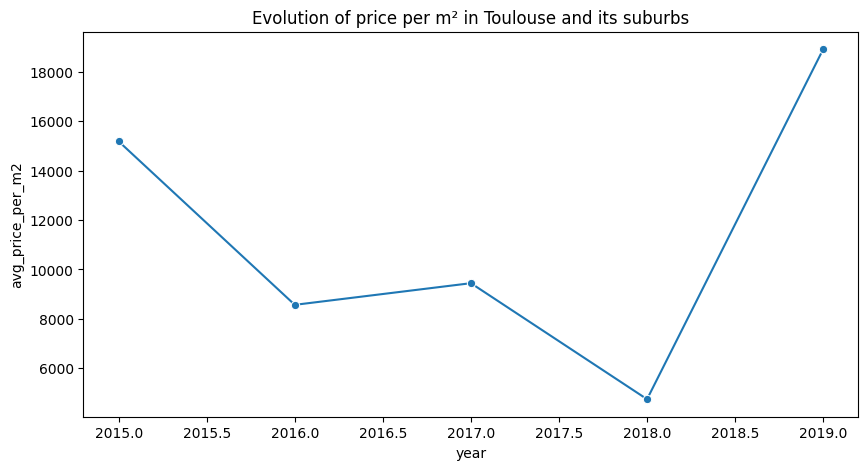

In [ ]:
# Average price per year
df_yearly = df.withColumn("year", year(col("SaleDate")))
price_trend = df_yearly.groupBy("year").agg(mean("price_per_m2").alias("avg_price_per_m2")).orderBy("year")
price_trend_pd = price_trend.toPandas()

#Create the plot
plt.figure(figsize=(10,5))
sns.lineplot(data=price_trend_pd, x="year", y="avg_price_per_m2", marker="o")
plt.title("Evolution of price per m² in Toulouse and its suburbs")
plt.show()

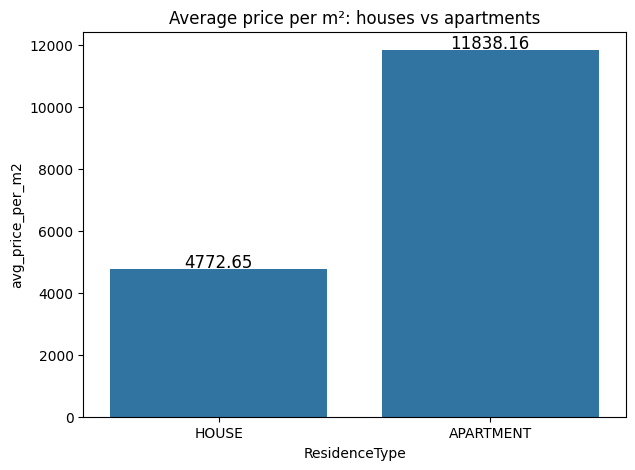

In [ ]:
# Differences between houses and apartments
house_vs_appt = df.groupBy("ResidenceType").agg(mean("price_per_m2").alias("avg_price_per_m2"))
house_vs_appt_pd = house_vs_appt.toPandas()

plt.figure(figsize=(7,5))
ax = sns.barplot(data=house_vs_appt_pd, x="ResidenceType", y="avg_price_per_m2")

# Add the average price per m² on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title("Average price per m²: houses vs apartments")
plt.show()

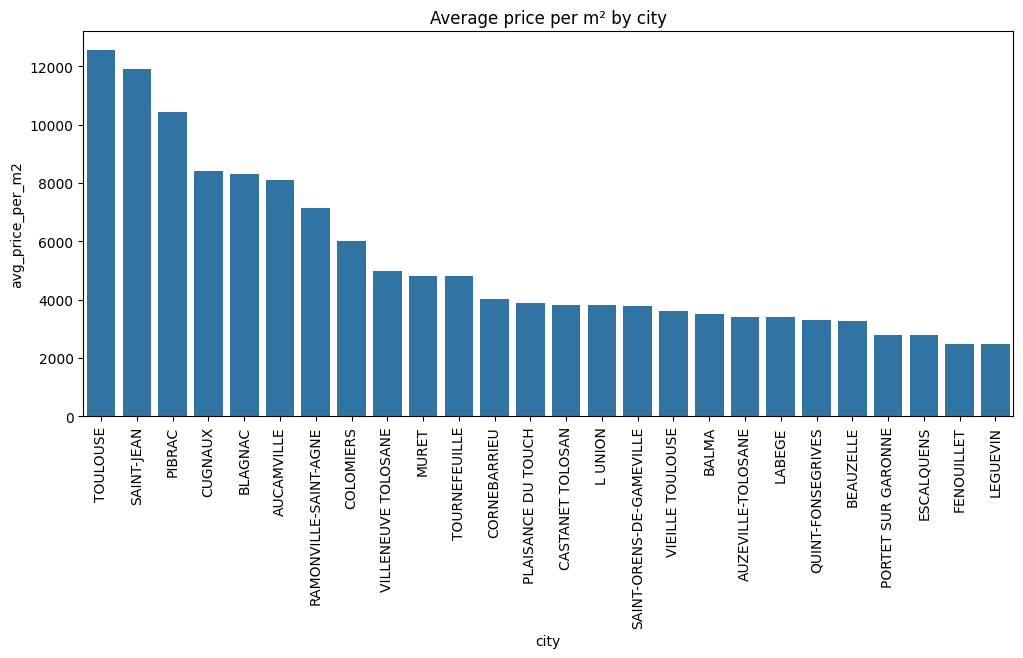

In [ ]:
# Geographical Analysis
city_prices = df.groupBy("city").agg(mean("price_per_m2").alias("avg_price_per_m2")).orderBy("avg_price_per_m2", ascending=False)
city_prices_pd = city_prices.toPandas()

plt.figure(figsize=(12,5))
sns.barplot(data=city_prices_pd, x="city", y="avg_price_per_m2")
plt.xticks(rotation=90, fontsize=10)  # Adjust the font size and the rotation of the ticks
plt.title("Average price per m² by city")
plt.show()

In [ ]:
# Detection of Outlier Sales
df_outliers = df.withColumn("outlier", when(col("price_per_m2") > df.approxQuantile("price_per_m2", [0.99], 0.05)[0], 1).otherwise(0))
outlier_count = df_outliers.filter(col("outlier") == 1).count()
print(f"Number of outlier sales detected: {outlier_count}")

Number of outlier sales detected: 0


<ipython-input-209-0f9308aab52d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_bar = sns.barplot(x="is_toulouse", y="avg_price_per_m2", data=toulouse_vs_suburbs_pd, palette=custom_palette)


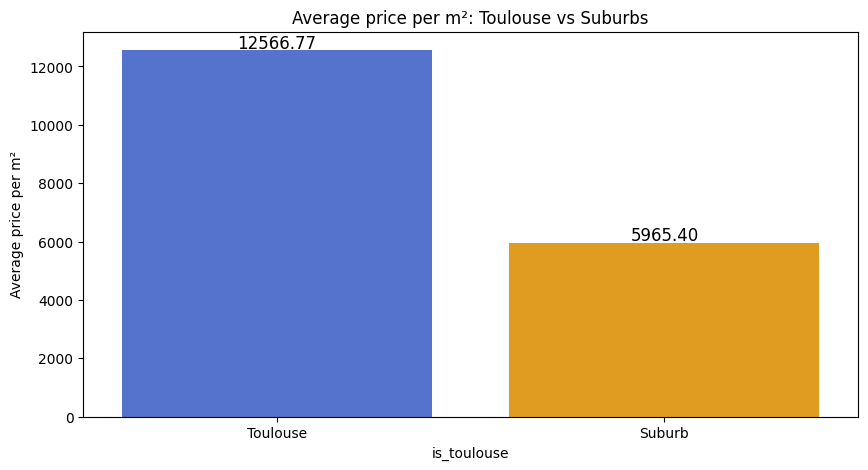

In [ ]:
# Differences between Toulouse and its suburbs

# Create a new column 'is_toulouse' to mark whether the city is Toulouse or not
df = df.withColumn("is_toulouse", when(col("City") == "TOULOUSE", "Toulouse").otherwise("Suburb"))

# Group by is_toulouse and calculate the average price per m²
toulouse_vs_suburbs = df.groupBy("is_toulouse").agg(mean("price_per_m2").alias("avg_price_per_m2"))

# Plotting the results
plt.figure(figsize=(10,5))

# Use the correct syntax to plot the data
sns_bar = sns.barplot(x="is_toulouse", y="avg_price_per_m2", data=toulouse_vs_suburbs_pd, palette=custom_palette)

# Adding the average price as text above each bar
for p in sns_bar.patches:
    sns_bar.annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     fontsize=12, color='black',
                     xytext=(0, 5), textcoords='offset points')

plt.title("Average price per m²: Toulouse vs Suburbs")
plt.ylabel("Average price per m²")
plt.show()

In [ ]:
# ESSAI POUR LA BONUS PART MAIS PAS CONCLUANT
# Filtrer les données pour Toulouse
df_toulouse = df.filter(df["City"] == "TOULOUSE")

# Filtrer les données pour les Suburbs (tout ce qui n'est pas Toulouse)
df_suburbs = df.filter(df["City"] != "TOULOUSE")

In [ ]:
# ESSAI POUR LA BONUS PART MAIS PAS CONCLUANT
from pyspark.sql.functions import col, mean

# Option 1: Remove rows with missing values in 'Price'
df = df.filter(df["Price"].isNotNull())

# Ensure the 'Price' column is of numeric type
df = df.withColumn("Price", col("Price").cast("double"))

# Use column names with the correct case
feature_cols = ["LivingArea", "NbRooms", "LandArea"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Apply the feature assembler
df_ml = assembler.transform(df).select("features", "Price")  # Make sure to use "Price" with the correct case

# Split the data into training and test sets
(train, test) = df_ml.randomSplit([0.8, 0.2])

# Create and train the Random Forest model
model = RandomForestRegressor(featuresCol="features", labelCol="Price")
model_fit = model.fit(train)

# Make predictions on the test set
predictions = model_fit.transform(test)

# Evaluate the model with RMSE metric
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Display the RMSE error
print(f"RMSE error of the model: {rmse}")

RMSE error of the model: 2140899.635398141
